In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)

Материалы этого ноутбука частично основаны на материалах курса от girafe ai: https://github.com/girafe-ai/ml-mipt

# Краткое напоминание: Линейная регрессия

Имеем датасет: $L = \{x_i, y_i\}_{i=1}^N$, где $x_i \in \mathbb{R}^n$, $y_i \in \mathbb{R}$

Модель линейная: $\hat{y} = w_0 + \sum\limits_{k=1}^{n} x_k \cdot w_k = ||{\bf x} = [1, x_1, x_2, ..., x_n] || = {\bf x}^T {\bf w}$,
где ${\bf w} = (w_0, w_1, ..., w_n)$, а $w_0$ отвечает за смещение

Тогда параметры модели можно найти следующим образом:

$\hat{{\bf w}} = \argmin\limits_{{\bf w}} L(Y, \hat{Y}) = \argmin\limits_{{\bf w}} L(Y, X{\bf w})$, где $X$ - матрица, в строках которой записаны обучающие примеры ${\bf x}_i$, в вектор $Y$ записаны обучающие метки $y_i$, а $L(Y, \hat{Y})$ - некоторая функция потерь

Функция потерь в выражении выше может быть различной. Наиболее часто используют L2 норму (MSE) и L1 норму (MAE)

При использовании L2 нормы в качестве функции потерь получим метод наименьших квадратов:
$\hat{{\bf w}} = \argmin\limits_{{\bf w}} ||Y - X{\bf w}||_2^2$

# Аналитическое решение

Введем квадратичную функцию потерь: $Q({\bf w}) = ||Y - X{\bf w}||_2^2 = (Y - X{\bf w})^T (Y - X{\bf w})$

Для нахождения оптимума приравняем к нулю производную:
$$\mathop{\nabla}_{{\bf w}} Q({\bf w}) = \mathop{\nabla}_{{\bf w}} [Y^T Y - Y^T X {\bf w} - {\bf w}^T X^T Y + {\bf w}^T X^T X {\bf w}] = \\
= 0 - X^T Y - X^T Y + (X^T X + X^T X){\bf w} = 0$$

Таким образом,
$$\hat{{\bf w}} = (X^T X)^{-1} X^T Y$$

# Практика
Сгенерируем матрицу признаков $X$ и матрицу весов $w_{true}$. Итоговый вектор $Y$ рассчитывается как $Y = X w_{true} + \epsilon$, где $\epsilon$ - гауссовый шум

In [2]:
import numpy as np

n_features = 2
n_objects = 300
np.random.seed(13)

# Let it be the *true* weights vector
w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))

# Here comes the *true* target vector
Y = X.dot(w_true) + np.random.normal(0, 1, n_objects)

Далее воспользуемся формулой, полученной выше

In [3]:
w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

In [4]:
w_star

array([-0.69329458,  0.73933638])

In [5]:
w_true

array([-0.71239066,  0.75376638])

Как видим, аналитическое решение близко к заранее заданным параметрам

Теперь сгенерируем датасет со скоррелированными признаками

In [6]:
n_features = 3
n_objects = 300
eps = 1e-3
np.random.seed(15)

# Let it be the *true* weights vector
w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))

# Now we duplicate the second feature with some small noise, so featues 2 and 3 are collinear
X[:, -1] = X[:, -2] + np.random.uniform(-eps, eps, X[:, -2].shape)

# Here comes the *true* target vector
Y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))

In [7]:
w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
w_star

array([  -0.33064383, -104.65147082,  104.8276029 ])

In [8]:
w_true

array([-0.31232848,  0.33928471, -0.15590853])

Как можнем видеть, теперь полученные и исходные веса значительно отличаются из-за нестабильности модели. Исправить это поможет регуляризация

Давайте добавим норму весов к имеющемуся лоссу, чтобы ограничить получаемое решение:

$Q_{reg}({\bf w}) = ||Y - X{\bf w}|| + \alpha ||{\bf w}||$

Здесь нужно быть внимательными к обозначениям, поскольку штрафовать модель за слагаемое, отвечающее за смещение явно не стоит, и его включать в регуляризационное слагаемое не следует

Используя L2 норму для весов и регуляризациооного слагаемого получим Ridge регрессию.
Можно показать, что аналитическое решение Ridge регрессии выглядит следующим образом:

${\bf w^*} = (X^T X + \alpha E)^{-1} X^T Y$, где E - единичная матрица

In [9]:
w_star_reg = np.linalg.inv(X.T.dot(X) + 0.05*np.eye(n_features)).dot(X.T).dot(Y)
w_star_reg

array([-0.32851076, -0.01702349,  0.19252876])

In [10]:
w_true

array([-0.31232848,  0.33928471, -0.15590853])

Теперь значения параметров не зашкаливают, что добавит в нашу модель стабильности

На деле обычно имеем большое количество как признаков, так и точек. В связи с этим, обращать матрицу выходит довольно затратно. Поэтому для решения поставленной задачи оптимизации можно также использовать градиентный спуск. В sklearn для линейных моделей градиентный спуск реализован в классе SGDRegressor

# Примеры

## Базовое использование

Создадим датасет

In [11]:
n_features = 25
n_objects = 50000
np.random.seed(13)

w_true = np.random.normal(-1, 1, size=n_features)

X = np.random.uniform(-10, 10, size=(n_objects, n_features))
Y = X.dot(w_true) + np.random.normal(-5, 5, n_objects)

Посмотрим на скоррелированность признаков

<AxesSubplot:>

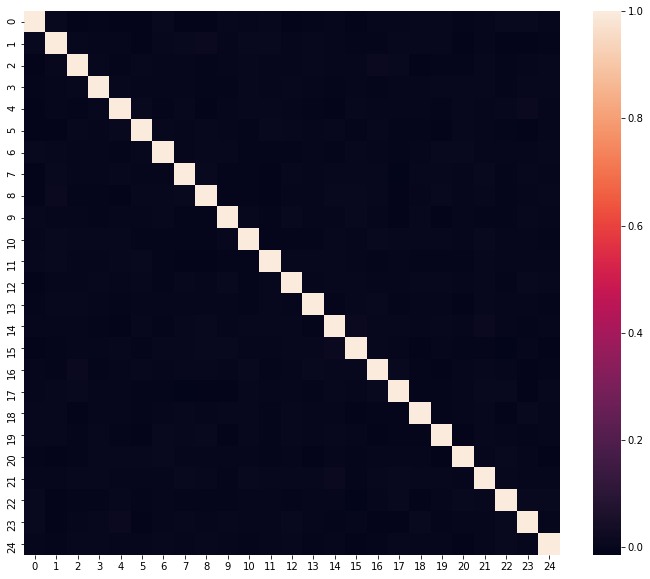

In [12]:
import seaborn as sns
import pandas as pd
plt.figure(figsize=(12, 10))
sns.heatmap(pd.DataFrame.from_records(X).corr())

Ожидаемо, признаки не скоррелированы, поскольку были сгенерированы случайным образом

Разобьем данные на train/test с помощью встроенного в sklearn метода

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=13)

В sklearn есть реализация линейной регрессии с различными функциями потерь и различными вариантами реализации.

Вариант линейной регрессии с функцией ошибки MSE без регуляризации в sklearn реализован в классе LinearRegression

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Модель построили, но как понять качество построенной модели? В этом нам помогут метрики качества
Вот некоторые из них:

Mean Squared Error (MSE): $L(y, \hat{y}) = \frac{||y - \hat{y}||_2^2}{N}$

Mean Absolute Error (MAE): $L(y, \hat{y}) = \frac{||y - \hat{y}||_1}{N}$

Эти две метрики могут нам что-то сказать лишь при условии, когда мы понимаем, в каком масштабе наша целевая переменная

Есть метрики, которые дают относительную точность предсказания

Mean Absolute Percentage Error (MAPE): $L(y, \hat{y}) = \frac{1}{N}\sum\limits_{i=1}^{N}\frac{|y_i - \hat{y_i}|}{|y_i|}$

R^2: $L(y, \hat{y}) = 1 - \frac{||y - \hat{y}||_2^2}{||y - \overline{y}||_2^2}$

Рассчитаем некоторые из них

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
print(f'MSE: {mean_squared_error(y_test, y_pred):.4f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.4f}')

MSE: 24.5194
MAE: 3.9587


Сами по себе эти значения не дают большого предствления о качестве работы модели, нужен дополнительный анализ значений, которые нужно предсказывать

In [17]:
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred):.4f}')
print(f'R^2: {r2_score(y_test, y_pred):.4f}')

MAPE: 1.2665
R^2: 0.9779


Видим, что R^2 показывает хорошее качество регрессии, а вот MAPE показывает просто ужасное качество (126.65 %). Это связано с тем, что имеются значения $y$ очень близкие к 0, что сильно завышает нам метрику. Поэтому нужно внимательно отнестись к тем данным, над которыми применяем тот или иной функционал качества

Пример точек, которые завышают нам MAPE

In [18]:
idx = np.argmin(np.abs(y_test))
print(f'y_true[{idx}] = {y_test[idx]}')
print(f'y_pred[{idx}] = {y_pred[idx]}')

y_true[7336] = -0.0015699479804318628
y_pred[7336] = 6.810817039182379


## Lasso и Ridge

Далее внесем скоррелированность в некоторые из признаков, просто скопировав значения других столбцов с небольшим шумом

In [19]:
eps = 0.05
X[:, 10] = X[:, 11] + np.random.normal(-eps, eps, size=n_objects)
X[:, 12] = X[:, 14] + np.random.normal(-eps, eps, size=n_objects)
X[:, 13] = X[:, 14] + np.random.normal(-eps, eps, size=n_objects)
Y = X.dot(w_true) + np.random.normal(-5, 5, n_objects)

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=13)

<AxesSubplot:>

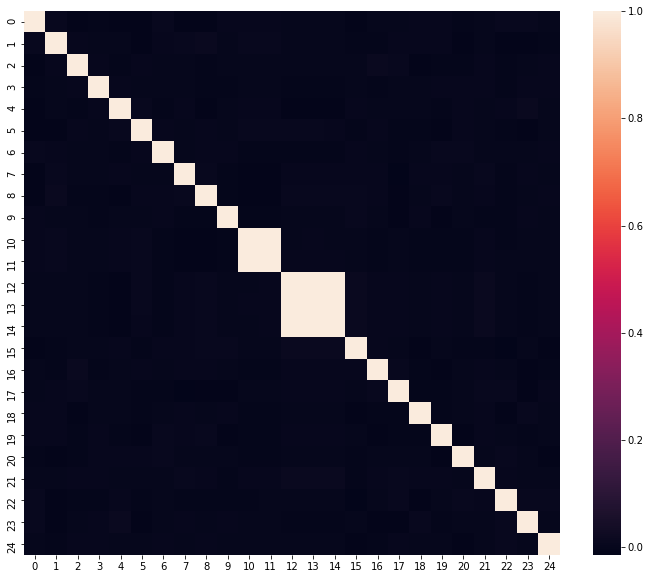

In [20]:
plt.figure(figsize=(12, 10))
sns.heatmap(pd.DataFrame.from_records(X).corr())

Как видим, появились скоррелированные признаки

Сравним поведение моделей с регуляризацией.

В качестве первой модели возьмем Ridge-регрессию, которая оптимизирует функцию $Q({\bf w}) = ||Y - X{\bf w}||_2^2 + \alpha ||{\bf w}||_2^2$

В качестве второй модели возьмем Lasso-регрессию, которая оптимизирует функцию $Q({\bf w}) = ||Y - X{\bf w}||_2^2 + \alpha ||{\bf w}||_1$


In [21]:
from sklearn.linear_model import Ridge, Lasso
ridge = Ridge()
lasso = Lasso()

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

print(f'MAE (Ridge): {mean_absolute_error(y_test, ridge.predict(X_test))}')
print(f'MAE (Lasso): {mean_absolute_error(y_test, lasso.predict(X_test))}')

MAE (Ridge): 4.047943078510971
MAE (Lasso): 4.099202247902773


Результат примерно одинаковый, так в чем же разница?

Напомним, что у нас были скоррелированы признаки 10 и 11, а также 12, 13 и 14

Выведем коэфициенты для этих двух методов

In [22]:
from IPython.display import display_markdown
display_markdown(f'''
Table of w[i] on correlated features:
| i | $w_i$ (ridge) | $w_i$ (lasso) |
|---|---|---|
| 10  |  {ridge.coef_[10]:.4f}  | {lasso.coef_[10]:.4f} |
| 11  |  {ridge.coef_[11]:.4f}  | {lasso.coef_[11]:.4f} |
| 12  |  {ridge.coef_[12]:.4f}  | {lasso.coef_[12]:.4f} |
| 13  |  {ridge.coef_[13]:.4f}  | {lasso.coef_[13]:.4f} |
| 14  |  {ridge.coef_[14]:.4f}  | {lasso.coef_[14]:.4f} |
''', raw=True)


Table of w[i] on correlated features:
| i | $w_i$ (ridge) | $w_i$ (lasso) |
|---|---|---|
| 10  |  -1.0748  | -4.0168 |
| 11  |  -2.9726  | -0.0006 |
| 12  |  -0.0039  | -1.7389 |
| 13  |  -1.0142  | -0.0009 |
| 14  |  -0.7515  | -0.0000 |


Можно заметить интересную картину, в lasso занулены все скоррелированные признаки, кроме одной. Поскольку вес нулевой, то модель не использует признаки, соответствующие зануленным весам. Это наталкивает на мысль, что Lasso-регрессия производит отбор признаков. Пояснить это поможет картинка, представленная ниже

![Image](https://www.i2tutorials.com/wp-content/media/2020/02/Elastic-Net-Regression-1-i2tutorials.png)

В sklearn третий вариант с суммой двух норм реализован с помощью класса ElasticNet

## Различия в функции потерь

Далее рассмотрим несколько разных функций потерь

До этого мы рассматривали L1 и L2 норму. На практике часто используют некоторый гибрид линейной и квадратичной функции ошибок, Huber loss.

Huber loss: $L(y_i, \hat{y_i}) = 
\begin{cases}
    \frac{1}{2} (y_i - \hat{y_i})^2 ,& \text{if } |y_i - \hat{y_i}| \leq \epsilon\\
    \epsilon (|y_i - \hat{y_i}| - \frac{1}{2} \epsilon),              & \text{otherwise}
\end{cases}$

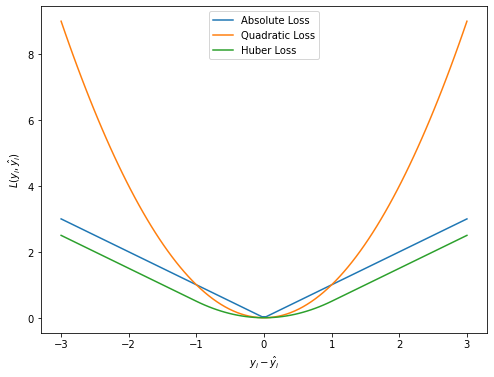

In [24]:
grid = np.linspace(-3, 3, 100)
mse_loss = grid ** 2
mae_loss = np.abs(grid)
huber_loss = 0.5 * mse_loss * (grid >= -1) * (grid <= 1) + (mae_loss - 0.5) * (grid < -1) + (mae_loss - 0.5)  * (grid > 1)
plt.plot(grid, mae_loss, label="Absolute Loss")
plt.plot(grid, mse_loss, label="Quadratic Loss")
plt.plot(grid, huber_loss, label="Huber Loss")
plt.xlabel("$y_i - \hat{y_i}$")
plt.ylabel("$L(y_i, \hat{y_i})$")
plt.legend()

Другие функции потерь помимо квадратичной нужны для того, чтобы минимизировать влияние выбросов на результат. В случае с абсолютной ошибкой, ее реализации нет в sklearn, зато есть реализация Huber loss. На его примере и покажем

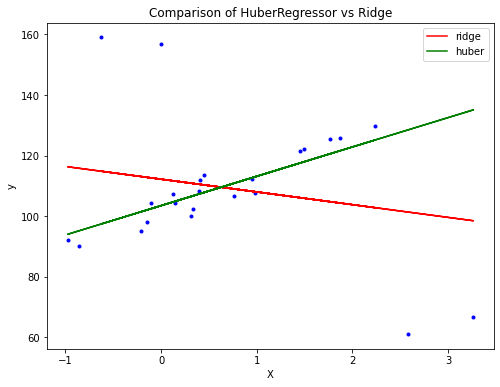

In [25]:
from sklearn.datasets import make_regression
from sklearn.linear_model import HuberRegressor

rng = np.random.RandomState(0)
X, y = make_regression(
    n_samples=20, n_features=1, random_state=0, noise=4.0, bias=100.0
)

# Add four strong outliers to the dataset.
X_outliers = rng.normal(0, 0.5, size=(4, 1))
y_outliers = rng.normal(0, 2.0, size=4)
X_outliers[:2, :] += X.max() + X.mean() / 4.0
X_outliers[2:, :] += X.min() - X.mean() / 4.0
y_outliers[:2] += y.min() - y.mean() / 4.0
y_outliers[2:] += y.max() + y.mean() / 4.0
X = np.vstack((X, X_outliers))
y = np.concatenate((y, y_outliers))

plt.plot(X, y, "b.")

model_huber = HuberRegressor().fit(X, y)
model_ridge = Ridge().fit(X, y)

plt.plot(X, model_ridge.predict(X), 'r-' ,label='ridge')
plt.plot(X, model_huber.predict(X), 'g-' ,label='huber')

plt.title("Comparison of HuberRegressor vs Ridge")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

## Нормировка данных

В машинном обучении считается хорошей практикой отнормировать данные перед подачей в модель. Это нужно для ускорения сходимости и корректной работы регуляризации.

В наиболее часто используемыми методади нормировки считаются MinMaxScaler и StandardScaler из sklearn.

Преобразование StandardScaler: $z = \frac{x - u}{s}$, где $u$ - среднее по $x$, а $s$ - дисперсия

Преобразование MinMaxScaler: $z = \frac{x - min}{max - min}$, где $min, max$ берутся по выборке $x$

Сгенерируем датасет для примера

In [26]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
X, y = make_regression(n_samples=10000, n_features=25, random_state=0, noise=3.0, bias=10.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

Способ нормировки 1. Промежуточное преобразование

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Ridge()
model.fit(X_train_scaled, y_train)
print('R2:', model.score(X_test_scaled, y_test))

R2: 0.9996494469839055


Способ 2. Pipeline

Sklearn допускает объединение нескольких последовательных действий в одной с помощью пайплайнов

In [28]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    StandardScaler(),
    Ridge(),
)

pipeline.fit(X_train, y_train)
print('R2:', pipeline.score(X_test, y_test))

R2: 0.9996494469839055


## Линейная модель для нелинейных задач

Сгенерируем датасет, состоящий из полинома 3 степени с шумом

In [29]:
n_features = 1
n_objects = 1000

np.random.seed(13)
X = np.random.uniform(-4, 3, size=(n_objects, n_features))
y = (X - 2)*(X + 3)*X + np.random.uniform(-4, 4, size=(n_objects, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y)

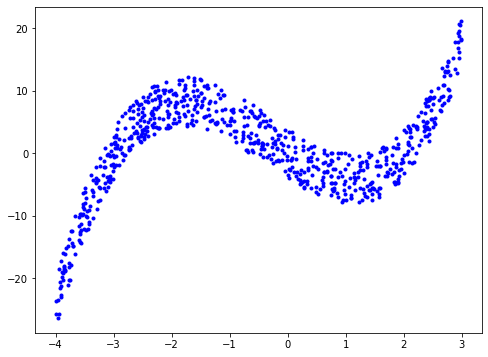

In [30]:
plt.plot(X_train, y_train, 'b.')

Видим, что с помощью просто линейной регрессии в этом случае задачу не решить, однако, если добавить в датасет отдельными признаками квадрат и куб исходного признака, то задачу вполне можно решить с помощью линейной регресии, покажем это

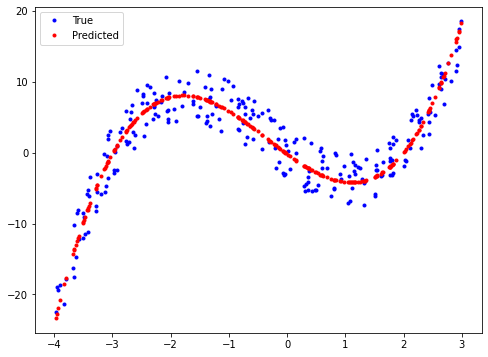

In [31]:
X_train_poly = np.hstack((X_train, X_train**2, X_train**3))
X_test_poly = np.hstack((X_test, X_test**2, X_test**3))

model = LinearRegression()
model.fit(X_train_poly, y_train)
y_pred = model.predict(X_test_poly)

plt.plot(X_test, y_test, 'b.', label='True')
plt.plot(X_test, y_pred, 'r.', label='Predicted')
plt.legend()

В случае, когда размерность исходного признакого пространства велика, генерация полиномиальных признаков вручную может быть проблематичной, поскольку уже для квадратов надо брать не только квадрат каждого признака, но и попарные произведения, что трудоемко. Для этой задачив sklearn есть готовое решение. Как им пользоваться покажем ниже 

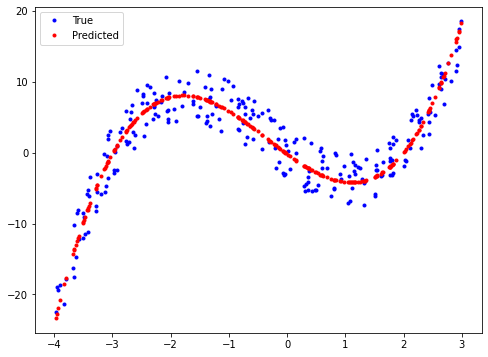

In [32]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=3)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)
y_pred = model.predict(X_test_poly)

plt.plot(X_test, y_test, 'b.', label='True')
plt.plot(X_test, y_pred, 'r.', label='Predicted')
plt.legend()

При желании добавить к этому всему еще и нормализацию перед подачей в модель появится большой объем кода, понадобится сохранять результаты после каждой итерации и нигде не ошибиться. Так что вполне удобно будет использовать Pipeline, который обсуждался ранее

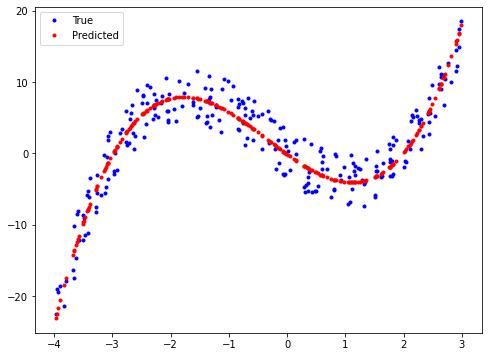

In [33]:
pipeline = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    Ridge(),
)

pipeline.fit(X_train, y_train)

plt.plot(X_test, y_test, 'b.', label='True')
plt.plot(X_test, pipeline.predict(X_test), 'r.', label='Predicted')
plt.legend()

## Применение на реальных данных

В качестве примера рассмотрим данные о ценах на недвижимость в Бостоне

Он состоит из следующих признаков:
- CRIM per capita crime rate by town
- ZN proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS proportion of non-retail business acres per town
- CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX nitric oxides concentration (parts per 10 million)
- RM average number of rooms per dwelling
- AGE proportion of owner-occupied units built prior to 1940
- DIS weighted distances to five Boston employment centres
- RAD index of accessibility to radial highways
- TAX full-value property-tax rate per $10,000
- PTRATIO pupil-teacher ratio by town
- B 1000(Bk - 0.63)^2 where Bk is the proportion of black people by town
- LSTAT % lower status of the population
- MEDV Median value of owner-occupied homes in $1000’s

Предсказать нужно количественный признак (MEDV), отвечающий за прогрессирование заболевание через год

In [54]:
from sklearn.datasets import load_boston
import pandas as pd
X, y = load_boston(return_X_y=True)

In [55]:
df = pd.DataFrame.from_records(np.hstack((X, y.reshape((-1, 1)))), columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
                                                           'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'])

In [56]:
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


Имеем DataFrame, в котором содержится наш датасет

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


Как видим, в данных нет пропусков и все они уже в числовом формате. Если бы проруски присутствовали, то необходимо было бы выяснить с помощью разведочного анализа данных (EDA) распределения признаков (гистограммы) и определить, какие из признаков являются дискретными, а какие количественными. В зависимости от того, какие перед нами признаки, мы должны решить, как заполнять отсутствующие значения. Например, для дискретного признака мы должны посмотреть на баланс величин. В случае, если один класс этого признака превалирует над другими, мы должны принимать решение о том, какими значениями заполнить отсутствующее поле

In [58]:
df.mean()

CRIM         3.613524
ZN          11.363636
INDUS       11.136779
CHAS         0.069170
NOX          0.554695
RM           6.284634
AGE         68.574901
DIS          3.795043
RAD          9.549407
TAX        408.237154
PTRATIO     18.455534
B          356.674032
LSTAT       12.653063
MEDV        22.532806
dtype: float64

Можно заметить, что масштабы у разных признаков отличаются, поэтому будет хорошей идеей данные предварительно отнормировать


<AxesSubplot:>

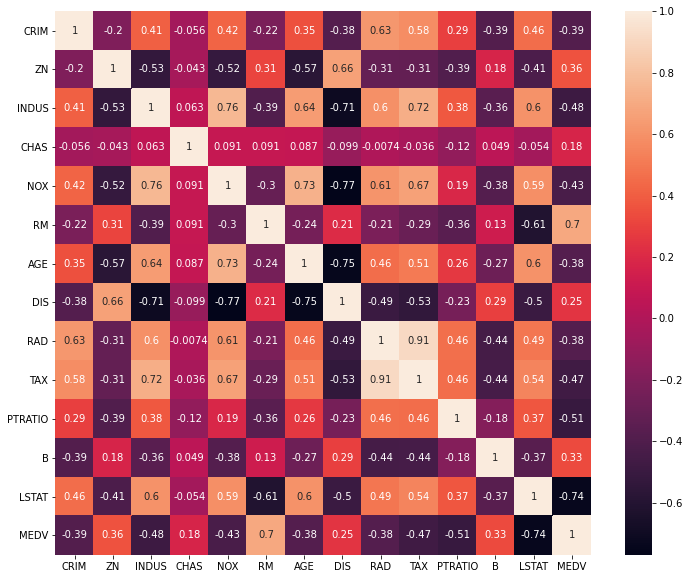

In [59]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True)

Построим pipeline

In [60]:
df.drop('DIS', inplace=True, axis=1)
X = df.drop('MEDV', axis=1).to_numpy()
y = df['MEDV'].to_numpy()

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

pipe = make_pipeline(
    StandardScaler(),
    Lasso(),
)

In [62]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAE: 3.877333260427212
MAPE: 0.20799757363465252


Посмотрим, улучшит ли ситуацию добавление полиномиальных признаков

In [63]:
pipe = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    Lasso()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAE: 3.31163227030069
MAPE: 0.17039284763784956


Видим, что предсказания немного улучшились

Нужно понимать, что любая модель оценивается с помощью определенной метрики. Такие метрики, как правило, определяются в процессе постановки задачи, и разработчик понимает для себя ориентиры, к которым необходимо подгонять свою модель. Таким образом, в процессе разработки специалист использует различные методы для улучшения стоковой модели и пытается построить модель такой, которая соответствует заявленным требованиям заказчика. В данном примере у нас не было цели показать наилучшую модель, так как мы не имели ориентиров и нашей целью было концептуально показать процесс построения модели.